# Import and config
Using this cell to import all the necessary libraries

In [1]:
# %pip install matplotlib

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from pipeline.build_dataset import make_state_frame
from features.state_assembler import StateAssembler
from envs.buy_env import BuyEnv
from agents.buy_agent_ddqn import BuyAgentTrainer


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Load config and data

In [3]:
cfg = yaml.safe_load(open("config/data_config.yaml"))

ticker = "AAPL"
dataset = make_state_frame(ticker, cfg)
print("Raw dataset shape:", dataset.shape)
print(dataset.tail())

[*********************100%***********************]  1 of 1 completed

Raw dataset shape: (1224, 10)
            return_1d     rsi14  macd_diff      bb_b     atr14     roc10  \
Date                                                                       
2023-12-22  -0.182761  0.089441  -0.627490 -0.178007 -1.820036 -0.282910   
2023-12-26  -0.538535 -0.175615  -0.849464 -0.533544 -1.984082 -0.573013   
2023-12-27  -0.341279 -0.314190  -1.030832 -0.759743 -2.209547 -0.357042   
2023-12-28  -0.084731 -0.299810  -1.123312 -0.790072 -2.209547 -0.531211   
2023-12-29   0.041515 -0.208810  -1.127638 -0.746858 -2.209547 -0.867667   

                 obv     mfi14   willr14       price  
Date                                                  
2023-12-22  1.349133 -0.061185 -0.080582  191.788773  
2023-12-26  1.259801 -0.044919 -0.988173  191.243896  
2023-12-27  1.190502 -0.392735 -1.621955  191.342957  
2023-12-28  1.300912 -0.723739 -1.453433  191.768951  
2023-12-29  1.382170 -0.785871 -1.292257  190.728790  


# Building rolling states

In [4]:
feature_cols = [c for c in dataset.columns if c != "price"]
assembler = StateAssembler(feature_cols=feature_cols, window_size=30)

state_df = assembler.assemble(dataset)
prices = dataset["price"].iloc[30:]  # align with state_df

print("state_df shape:", state_df.shape)
print("prices shape:", prices.shape)
print("NaNs in state_df:", state_df.isna().sum().sum())
print("NaNs in prices:", prices.isna().sum())


state_df shape: (1194, 270)
prices shape: (1194,)
NaNs in state_df: 0
NaNs in prices: 0


# Train DDQN Buy Agent

In [ ]:
trainer = BuyAgentTrainer(
        cfg_path="config/data_config.yaml",
        ticker="AAPL",
        window_size=30,
        horizon=5,
        transaction_cost=0.001,
    )

rewards = trainer.train(
    n_episodes=50,
    warmup_steps=10,
    max_steps_per_episode=None,
)

print("Last 10 episode rewards:", rewards[-10:])

greedy_policy = trainer.make_greedy_policy()
total_reward, steps = greedy_policy()
print(f"Greedy run: total_reward={total_reward:.4f}, steps={steps}")

[*********************100%***********************]  1 of 1 completed


[BuyTrainer] Raw dataset shape for AAPL: (1224, 10)
[BuyTrainer] After dropna: (1224, 10)
[BuyTrainer] Rolling state_df shape: (1194, 270)
[BuyTrainer] state_dim=270, n_actions=2
[Episode 1/50] Reward=2.2307, Epsilon=0.773
[Episode 10/50] Reward=18.3567, Epsilon=0.050
[Episode 20/50] Reward=16.6578, Epsilon=0.050
[Episode 30/50] Reward=16.0664, Epsilon=0.050
[Episode 40/50] Reward=18.0390, Epsilon=0.050
[Episode 50/50] Reward=17.3202, Epsilon=0.050
Training complete.
Final rewards: [18.93105563352583, 18.774938104557805, 16.832234492816497, 17.67517020367086, 17.60912642243784, 18.119207845418714, 18.338109426898882, 18.002961978665553, 18.186569747456815, 17.32020546332933]
Last 10 episode rewards: [18.93105563352583, 18.774938104557805, 16.832234492816497, 17.67517020367086, 17.60912642243784, 18.119207845418714, 18.338109426898882, 18.002961978665553, 18.186569747456815, 17.32020546332933]
Greedy run: total_reward=20.0637, steps=1193


# Plot training reward curve

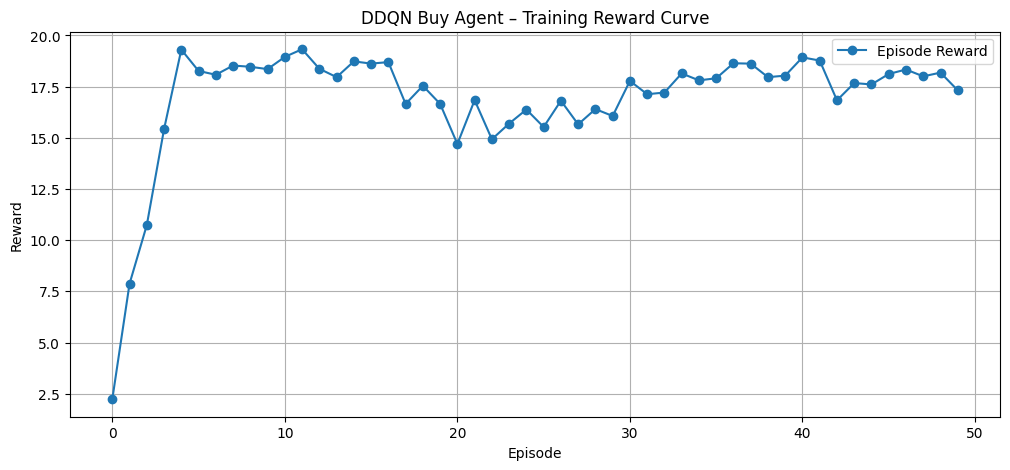

In [6]:
plt.figure(figsize=(12,5))
plt.plot(rewards, label="Episode Reward", marker="o")
plt.title("DDQN Buy Agent – Training Reward Curve")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()


# Buy signal

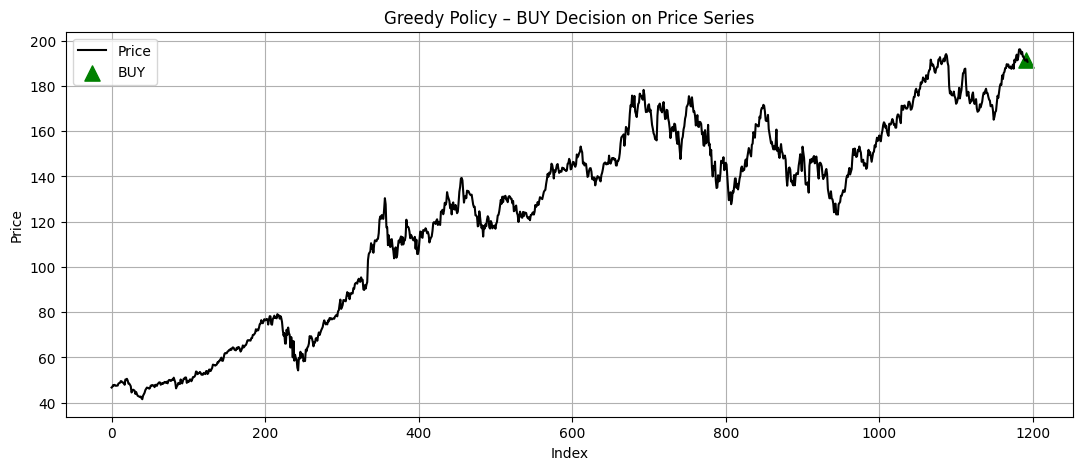

In [7]:
# Get environment price series
prices = trainer.prices.copy()
index = prices.index

# Re-run greedy to get signal points
env = trainer.env
state = env.reset()
done = False
buy_index = None

while not done:
    a = trainer.agent.select_action(state, greedy=True)
    if a == 1:   # BUY
        buy_index = env.idx
    state, r, done, info = env.step(a)

plt.figure(figsize=(13,5))
plt.plot(prices.values, label="Price", color="black")
if buy_index is not None:
    plt.scatter([buy_index], [prices.iloc[buy_index]], s=120, color="green", label="BUY", marker="^")
plt.title("Greedy Policy – BUY Decision on Price Series")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


# Loss history

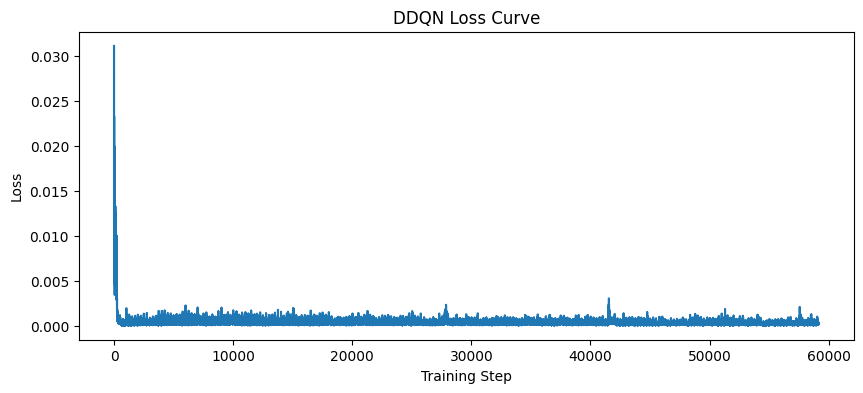

In [8]:
plt.figure(figsize=(10,4))
plt.plot(trainer.agent.loss_history)
plt.title("DDQN Loss Curve")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.show()


# Inspecting one simple state

In [9]:
sample = trainer.state_df.iloc[0]
print("Example state vector:", sample.values[:20], "... (total length:", len(sample), ")")


Example state vector: [ 0.32263345  0.66738992  0.30021209  0.49007165 -1.9164948  -0.20491722
  0.01857323  1.41689     0.19678294 -0.30519084  0.49234054  0.15419982
  0.33883114 -1.98983765 -0.29584127 -0.07254095  1.00533844 -0.36131781
  0.56564172  0.70682062] ... (total length: 270 )
